<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper/ecoli_modeling_with_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the perfomance of LSTM model on simulation of E. coli in a Laotian catchment with different transformations of E. coli.

In [1]:
try:
    import ai4water
except ModuleNotFoundError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

  Cloning https://github.com/AtrCheema/AI4Water.git (to revision dev) to /tmp/pip-install-nx6bnc55/AI4Water
  Running command git clone -q https://github.com/AtrCheema/AI4Water.git /tmp/pip-install-nx6bnc55/AI4Water
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 2.9MB 29.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 69.2MB 117kB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
     |████████████████████████████████| 225kB 43.9MB/s 
     |████████████████████████████████| 296kB 41.9MB/s 
     |████████████████████████████████| 460kB 42.9MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |███████████████

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt

from ai4water.utils.utils import plot, dateandtime_now
from ai4water.datasets import MtropicsLaos
from ai4water.preprocessing.resample import Resampler
from ai4water.experiments import TransformationExperiments

Download the data for Laos.

In [14]:
laos = MtropicsLaos()


Not downloading the data since the directory 
/usr/local/lib/python3.7/dist-packages/AI4Water/utils/datasets/data/MtropicsLaos already exists.
Use overwrite=True to remove previously saved files and download again


/usr/local/lib/python3.7/dist-packages/AI4Water/utils/datasets/datasets.py:1086: UserWarning:

preprocessing can not be done because no fiona installation is found.



Fetch precipitation data from 2011 to 2018

In [15]:
pcp = laos.fetch_pcp(st='20110101', en='20181231')
pcp = pcp.interpolate('linear', limit=5)
pcp = pcp.fillna(0.0)
pcp.shape

(701280, 1)

fetch weather station data

In [16]:
w = laos.fetch_weather_station_data("20110101", "20181231")
w.shape

(70128, 4)

fetch ecoli data

In [22]:
ecoli = laos.fetch_ecoli(en="20181231")
ecoli = ecoli.dropna()
ecoli.shape

(289, 1)

In [23]:
ecoli.head()

,E-coli_4dilutions
Date_Time,
2011-05-25 16:40:00,1100.0
2011-05-25 17:06:00,1400.0
2011-05-25 17:24:00,14000.0
2011-05-25 17:44:00,1300.0
2011-05-25 18:06:00,29000.0


In [24]:
ecoli_6min = ecoli.resample('6min').mean()
ecoli_6min.shape

(665756, 1)

In [25]:
ecoli_6min.head()

,E-coli_4dilutions
Date_Time,
2011-05-25 16:36:00,1100.0
2011-05-25 16:42:00,NaN
2011-05-25 16:48:00,NaN
2011-05-25 16:54:00,NaN
2011-05-25 17:00:00,NaN


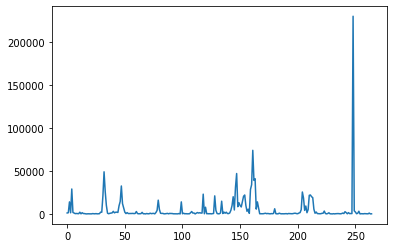

In [26]:
plot(ecoli_6min.dropna().values)

In [27]:
w = w.interpolate()
w = w.bfill()
assert int(w.isna().sum().sum()) == 0
w.head()

,temp,rel_hum,wind_speed,sol_rad
2011-01-01 00:00:00,15.7,100.0,0.0000,0.0
2011-01-01 01:00:00,15.6,100.0,0.0078,0.0
2011-01-01 02:00:00,15.3,100.0,0.0000,0.0
2011-01-01 03:00:00,15.0,100.0,0.0000,0.0
2011-01-01 04:00:00,16.1,100.0,0.0050,0.0


In [28]:
w.columns = ['temp', 'rel_hum', 'wind_speed', 'sol_rad']

w_6min = Resampler(w,
               freq='6min',
               how={'temp': 'linear',
                    'rel_hum': 'linear',
                    'wind_speed': 'linear',
                    'sol_rad':'linear'
                    }
               )()
w_6min.head()

,temp,rel_hum,wind_speed,sol_rad
2011-01-01 00:00:00,15.70,100.0,0.00000,0.0
2011-01-01 00:06:00,15.69,100.0,0.00078,0.0
2011-01-01 00:12:00,15.68,100.0,0.00156,0.0
2011-01-01 00:18:00,15.67,100.0,0.00234,0.0
2011-01-01 00:24:00,15.66,100.0,0.00312,0.0


In [29]:
st, en = ecoli_6min.index[0], ecoli_6min.index[-1]
data = pd.concat([w_6min[st:en], pcp[st:en], ecoli_6min], axis=1)
data.head()

,temp,rel_hum,wind_speed,sol_rad,pcp,E-coli_4dilutions
2011-05-25 16:36:00,29.734,84.48,0.8482,119.1484,0.0,1100.0
2011-05-25 16:42:00,30.028,83.46,0.8794,118.9263,0.0,NaN
2011-05-25 16:48:00,30.322,82.44,0.9106,118.7042,0.0,NaN
2011-05-25 16:54:00,30.616,81.42,0.9418,118.4821,0.0,NaN
2011-05-25 17:00:00,30.910,80.40,0.9730,118.2600,0.0,NaN


In [30]:
data.tail()

,temp,rel_hum,wind_speed,sol_rad,pcp,E-coli_4dilutions
2018-12-28 15:42:00,27.56,61.05,1.0,104.2,0.0,NaN
2018-12-28 15:48:00,27.54,61.70,1.0,99.8,0.0,NaN
2018-12-28 15:54:00,27.52,62.35,1.0,95.4,0.0,NaN
2018-12-28 16:00:00,27.50,63.00,1.0,91.0,0.0,NaN
2018-12-28 16:06:00,27.03,64.80,0.9,85.1,0.0,120.0


Define transformation cases

In [31]:
cases = {
    'model_None': {'y_transformation': None},
    'model_logn': {'y_transformation':{'method': 'log',
                              'replace_zeros': True,
                              'features': ['Ecoli_mpn100']}},
    'model_log10': {'y_transformation': {'method': 'log10',
                                     'replace_zeros': True,
                                     'features': ['Ecoli_mpn100']}},
    'model_robust': {'y_transformation': {'method': 'robust', 'features': ['Ecoli_mpn100']}},
    'model_zscore': {'y_transformation': {'method': 'zscore', 'features': ['Ecoli_mpn100']}},
    'model_minmax': {'y_transformation': {'method': 'minmax', 'features': ['Ecoli_mpn100']}},
    'model_quantile': {'y_transformation': {'method': 'quantile', 'features': ['Ecoli_mpn100']}},
}

arguments for model setup

In [32]:
model_args = {
    'epochs': 500,
    'patience': 50,
    'test_fraction': 0.25,
    'val_data': 'same',
    'train_data': 'random',
    'input_features': data.columns.tolist()[0:-1],
    'output_features': data.columns.tolist()[-1:],
    'verbosity': 0
}

In [33]:
class MyTransformationExperiment(TransformationExperiments):

    def update_paras(self, **suggested_paras):
        """This method must update all the parameters to build the dl4sq 'Model'."""
        return {
            'model': {
                'layers': {
                    "LSTM": {"units": suggested_paras.get('lstm_units', 64), "dropout": 0.2},
                    "Dense": 1
                }
            },
            'lookback': suggested_paras.get('lookback', 10),
            'batch_size': suggested_paras.get('batch_size', 8),
            'lr': suggested_paras.get('lr', 0.001),
            'y_transformation': suggested_paras['y_transformation']
        }

Initialize the experiment

In [34]:
experiment = MyTransformationExperiment(data=data,
                                        cases=cases,
                                        exp_name='ecoli_output_transformation',
                                        **model_args)

In [35]:
experiment.models

['model_None',
 'model_logn',
 'model_log10',
 'model_robust',
 'model_zscore',
 'model_minmax',
 'model_quantile']

running  model_None model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/utils/SeqMetrics/SeqMetrics.py:1355: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

loo


********** Allowing NANs in predictions **********

running  model_logn model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to 


********** Allowing NANs in predictions **********

running  model_log10 model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to 


********** Allowing NANs in predictions **********

running  model_robust model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to 


********** Allowing NANs in predictions **********

running  model_zscore model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to 


********** Allowing NANs in predictions **********

running  model_minmax model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to 


********** Allowing NANs in predictions **********

running  model_quantile model


/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:1255: UserWarning:

Setting val_fraction from 0.2 to 0.0

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to some wrong
                                              examples at the start or an offset of 2 in indices.

/usr/local/lib/python3.7/dist-packages/AI4Water/main.py:531: UserWarning:

lookback is 10, due to which first 7
                                              nan containing values were skipped from start. This may lead to 


********** Allowing NANs in predictions **********



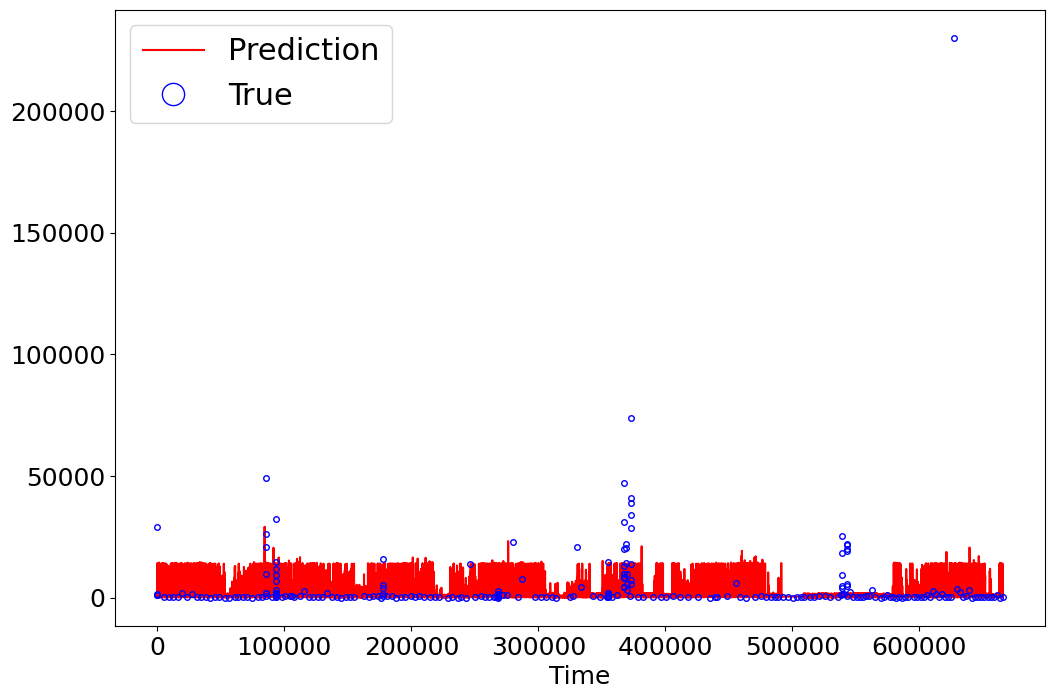

In [36]:
experiment.fit()

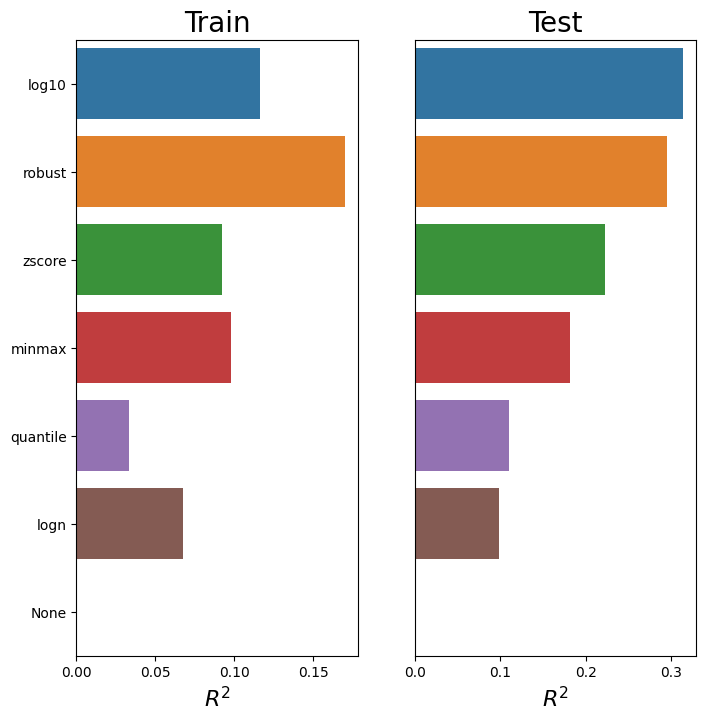

{6.086889700779412e-34: [nan, 'None'],
 0.09913017389260305: [0.0677829969411574, 'logn'],
 0.10992073109332368: [0.033251396361854285, 'quantile'],
 0.18131545064095214: [0.09781836893551234, 'minmax'],
 0.22207090397875695: [0.09237741414900491, 'zscore'],
 0.29501975111425466: [0.17001216168720407, 'robust'],
 0.31371459876127644: [0.11639517053909419, 'log10']}

In [37]:
experiment.compare_errors('r2')

Note htat `None` results in `nan` $R^2$

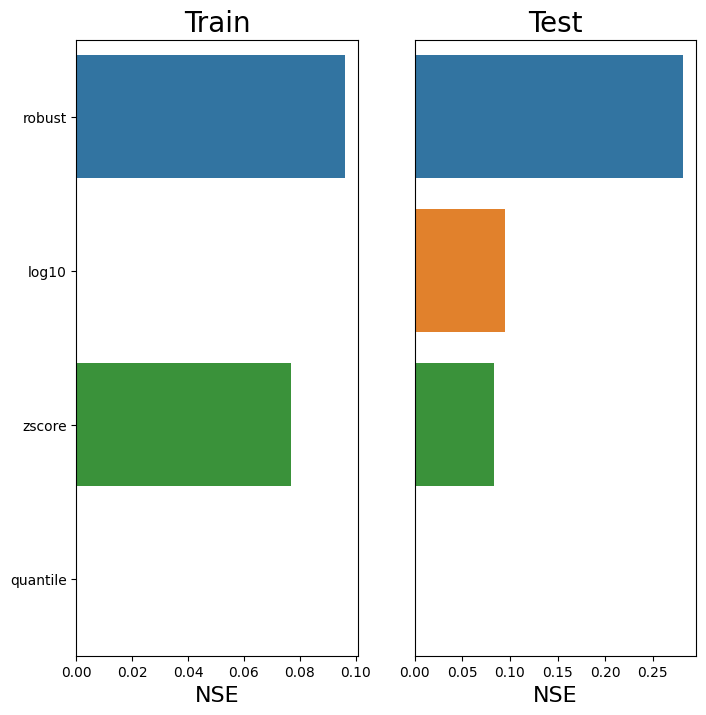

In [38]:
errs = experiment.compare_errors('nse')

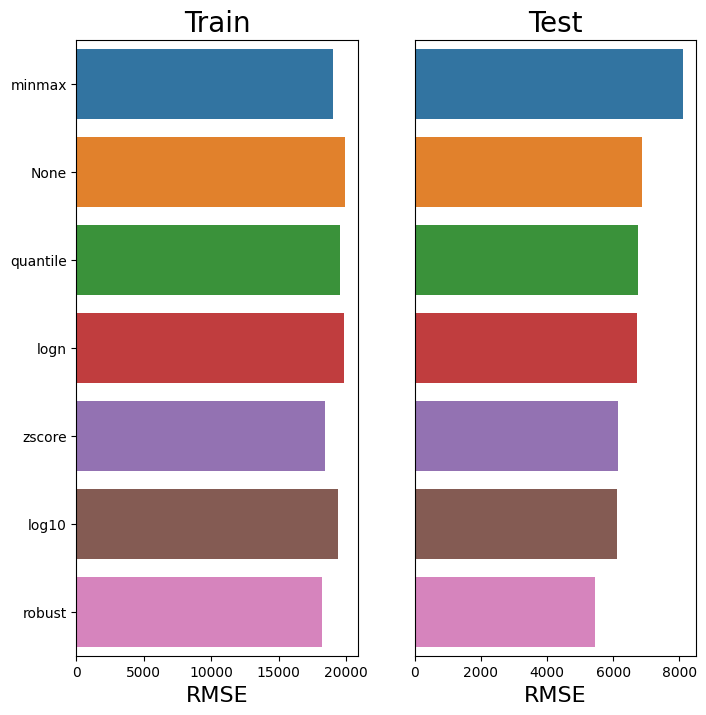

In [39]:
errs = experiment.compare_errors('rmse')

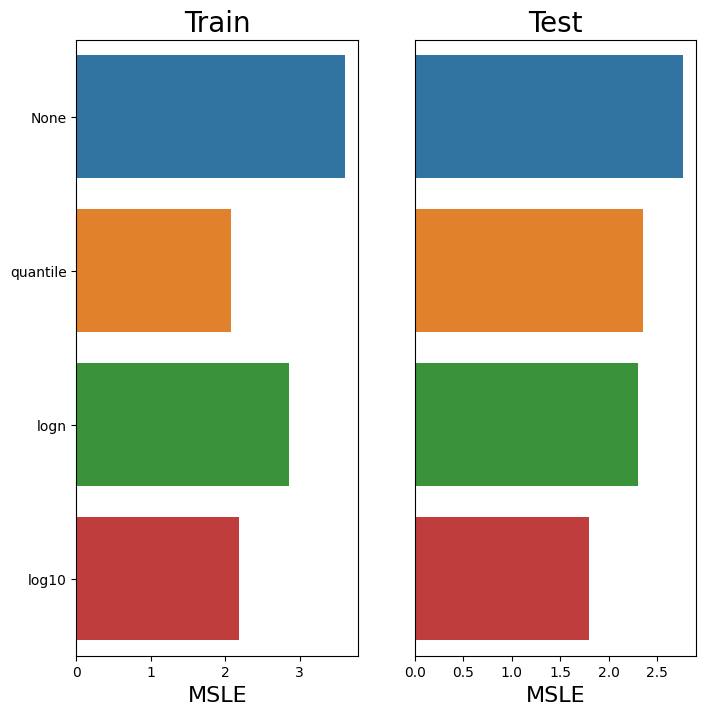

In [40]:
errs = experiment.compare_errors('msle')

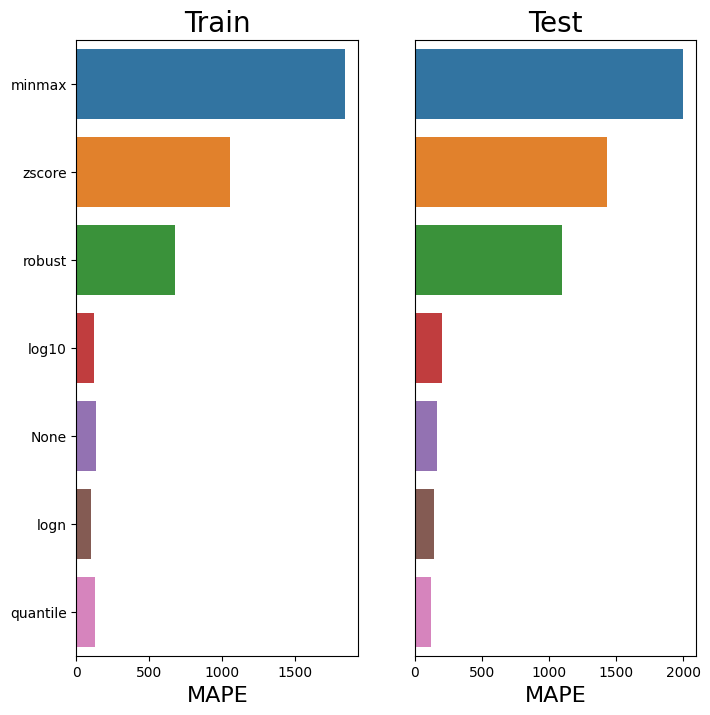

In [41]:

errs = experiment.compare_errors('mape')

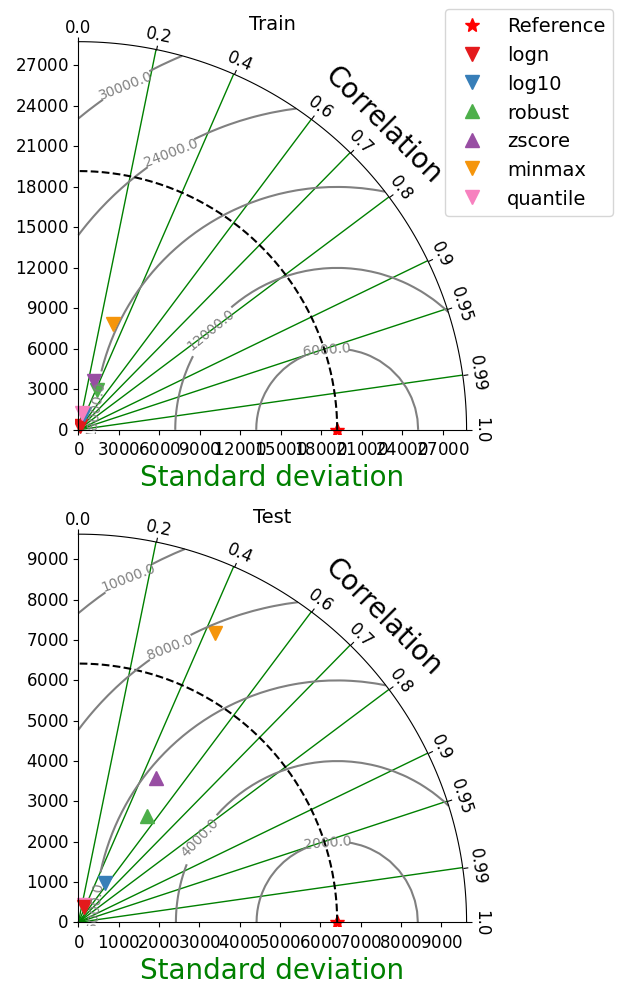

In [54]:
experiment.taylor_plot(
             include=[
 'model_logn',
 'model_log10',
 'model_robust',
 'model_zscore',
 'model_minmax',
 'model_quantile'],
             figsize=(7, 14),
             save=True,
             plot_bias=True,
             grid_kws={'axis': 'x', 'color': 'g', 'lw': 1.0},
             leg_kws = {'fontsize': 14},
             axis_fontdict ={'left': {'fontsize': 20, 'color': 'k', 'ticklabel_fs': 12},
                             'bottom': {'fontsize': 20, 'color': 'g', 'ticklabel_fs': 12},
                             'top': {'fontsize': 20, 'color': 'k', 'ticklabel_fs': 12}}
            )